In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import math
import methods
import itertools

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}

In [3]:
transform = transforms.Compose( [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), transforms.RandomHorizontalFlip(p=0.5)] )

cifar_train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_test_set = datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)

Files already downloaded and verified


In [4]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
batch_size = 64

In [6]:
train_loader = torch.utils.data.DataLoader(cifar_train_set, batch_size=batch_size, shuffle=True)

In [7]:
def gen_rand_imgs(shape):
  return torch.rand(shape)

In [119]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    # self.seq1 = self._gen_sequence(3, 16)
    self.fc1 = nn.Linear(3*32*32, 256)
    self.fc2 = nn.Linear(256, 1)

  def _gen_sequence(self, in_channels, out_channels):
    return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, 3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(),
      nn.MaxPool2d(2)
    )

  def forward(self, x):
    batch = x.shape[0]
    # x = self.seq1(x)
    x = x.reshape(batch, -1)
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    x = torch.sigmoid(x)
    return x.flatten()

In [120]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.fc1 = nn.Linear(100, 16*4*4)
    self.seq1 = self._gen_sequence(16, 32)
    self.seq2 = self._gen_sequence(32, 32)
    self.seq3 = self._gen_sequence(32, 16)
    self.fin_conv = nn.Conv2d(16, 3, 3, padding=1)

  
  def _gen_sequence(self, in_channels, out_channels):
    return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, 3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, x):
    x = F.leaky_relu(self.fc1(x))
    x = x.reshape(-1, 16, 4, 4)
    x = F.leaky_relu(self.seq1(x))
    x = F.leaky_relu(self.seq2(x))
    x = F.leaky_relu(self.seq3(x))
    x = F.leaky_relu(self.fin_conv(x))
    return x

In [121]:
def set_model_freeze(model, freeze=True):
  for key, value in model.named_parameters():
    value.requires_grad = freeze

In [122]:
g_net = Generator()
d_net = Discriminator()

if device == 'cuda':
    g_net = g_net.cuda()
    d_net = d_net.cuda()

# train discriminator

In [123]:
epoch_num = 100
criterion = nn.BCELoss()
d_lr = 1e-4
g_lr = 1e-4
d_optimizer = torch.optim.Adam(d_net.parameters(), lr = d_lr)
g_optimizer = torch.optim.Adam(g_net.parameters(), lr = g_lr)

all_ones = torch.ones(batch_size, dtype=torch.float32).to(device)
all_zeros = torch.zeros(batch_size, dtype=torch.float32).to(device)

In [124]:
# set_model_freeze(g_net, True)

In [125]:
test_real_imgs = None
for _, imgs in enumerate(train_loader):
  test_real_imgs = imgs[0]
  break

In [126]:
def gen_real_fake_batch(real_imgs):
  fake_imgs = gen_rand_imgs([real_imgs.shape[0], 100])

  real_imgs = real_imgs.to(device)
  fake_imgs = fake_imgs.to(device)

  fake_out = torch.sigmoid(g_net(fake_imgs))

  return real_imgs, fake_out

In [127]:
def test_discriminator_accuracy():
  d_net.eval()
  g_net.eval()
  ri, fi = gen_real_fake_batch(test_real_imgs)
  ro = d_net(ri)
  fo = d_net(fi)
  # print(ro[:10], fo[:10])
  ro = torch.round(ro)
  fo = torch.round(fo)
  d_net.train()
  g_net.train()
  print('real: ', torch.sum(ro == all_ones).item(), 'fake: ', torch.sum(fo == all_zeros).item())
  return (torch.sum(ro == all_ones) + torch.sum(fo == all_zeros)).item() / (test_real_imgs.shape[0]*2)

In [128]:
def test_generator_efficiency():
  d_net.eval()
  g_net.eval()
  zz = gen_rand_imgs([batch_size, 100]).to(device)
  fake_imgs = torch.sigmoid(g_net(zz))
  fake_preds = d_net(fake_imgs)

  fake_preds = torch.round(fake_preds)
  d_net.train()
  g_net.train()
  return torch.sum(fake_preds == all_ones).item() / 64

In [129]:
test_discriminator_accuracy()

real:  21 fake:  0


0.1640625

In [130]:
test_generator_efficiency()

1.0

In [131]:
def get_norm_loss(input):
  input_f = input.reshape(input.shape[0], -1)
  return torch.mean(torch.norm(input_f, dim=1) / input_f.shape[0])


In [132]:
def show_example():
  a = torch.rand([1, 100]).to(device)
  b = torch.sigmoid(g_net(a))
  b = torch.sigmoid(b)
  b_np = b[0].permute(1,2,0).cpu().detach().numpy()
  plt.imshow(b_np)
  plt.show()

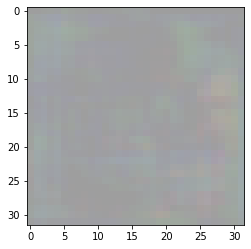

In [133]:
show_example()

In [134]:
a = torch.rand([1, 100]).to(device)
b = torch.sigmoid(g_net(a))
b = torch.sigmoid(b)
c = d_net(b)
c

tensor([0.5556], device='cuda:0', grad_fn=<ViewBackward>)

real:  62 fake:  64
d: 0.984375   g: 0.0    gl: 1.559274435043335
real:  62 fake:  64
d: 0.984375   g: 0.0    gl: 1.2227623462677002
real:  62 fake:  64
d: 0.984375   g: 0.0    gl: 1.1496741771697998
real:  62 fake:  64
d: 0.984375   g: 0.0    gl: 1.138135313987732
real:  62 fake:  64
d: 0.984375   g: 0.0    gl: 1.1508454084396362
real:  62 fake:  64
d: 0.984375   g: 0.0    gl: 1.180722713470459
real:  62 fake:  64
d: 0.984375   g: 0.0    gl: 1.2229453325271606
real:  62 fake:  64
e:  1 @@@@@@@@@@ d: 0.984375   g: 0.0


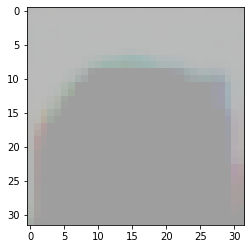

real:  62 fake:  64
d: 0.984375   g: 0.0    gl: 1.2751916646957397
real:  62 fake:  64
d: 0.984375   g: 0.0    gl: 1.3346929550170898
real:  62 fake:  64
d: 0.984375   g: 0.0    gl: 1.399035930633545
real:  62 fake:  64
d: 0.984375   g: 0.0    gl: 1.4670484066009521
real:  62 fake:  64
d: 0.984375   g: 0.0    gl: 1.536546230316162
real:  62 fake:  64
d: 0.984375   g: 0.0    gl: 1.6081098318099976
real:  62 fake:  64
d: 0.984375   g: 0.0    gl: 1.6800602674484253
real:  62 fake:  64
d: 0.984375   g: 0.0    gl: 1.7507834434509277
real:  62 fake:  64
e:  2 @@@@@@@@@@ d: 0.984375   g: 0.0


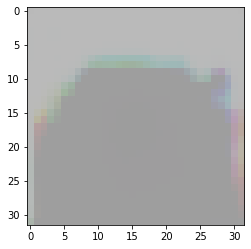

real:  62 fake:  64
d: 0.984375   g: 0.0    gl: 1.8208527565002441
real:  62 fake:  64
d: 0.984375   g: 0.0    gl: 1.8888611793518066
real:  62 fake:  64
d: 0.984375   g: 0.0    gl: 1.9526302814483643
real:  62 fake:  64
d: 0.984375   g: 0.0    gl: 2.01230525970459
real:  62 fake:  64
d: 0.984375   g: 0.0    gl: 2.068793296813965
real:  62 fake:  64
d: 0.984375   g: 0.0    gl: 2.1205689907073975
real:  62 fake:  64
d: 0.984375   g: 0.0    gl: 2.167602062225342
real:  62 fake:  64
d: 0.984375   g: 0.0    gl: 2.210675001144409
real:  62 fake:  64
e:  3 @@@@@@@@@@ d: 0.984375   g: 0.0


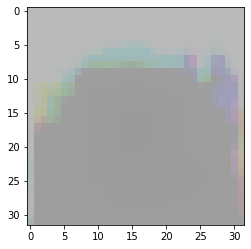

real:  62 fake:  64
d: 0.984375   g: 0.0    gl: 2.250537157058716
real:  61 fake:  64
d: 0.9765625   g: 0.0    gl: 2.2859692573547363
real:  61 fake:  64
d: 0.9765625   g: 0.0    gl: 2.3169283866882324
real:  61 fake:  64
d: 0.9765625   g: 0.0    gl: 2.332756519317627
real:  61 fake:  64
d: 0.9765625   g: 0.0    gl: 2.341484308242798
real:  61 fake:  64
d: 0.9765625   g: 0.0    gl: 2.3516626358032227
real:  60 fake:  64
d: 0.96875   g: 0.0    gl: 2.3610146045684814
real:  60 fake:  64
d: 0.96875   g: 0.0    gl: 2.369903564453125
real:  60 fake:  64
e:  4 @@@@@@@@@@ d: 0.96875   g: 0.0


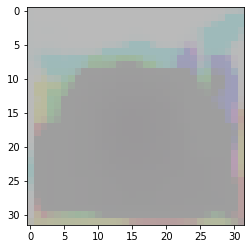

real:  60 fake:  64
d: 0.96875   g: 0.0    gl: 2.3776941299438477
real:  60 fake:  64
d: 0.96875   g: 0.0    gl: 2.3832411766052246
real:  60 fake:  64
d: 0.96875   g: 0.0    gl: 2.389364719390869
real:  60 fake:  64
d: 0.96875   g: 0.0    gl: 2.395315408706665
real:  60 fake:  64
d: 0.96875   g: 0.0    gl: 2.4007747173309326
real:  60 fake:  64
d: 0.96875   g: 0.0    gl: 2.4054744243621826
real:  59 fake:  64
d: 0.9609375   g: 0.0    gl: 2.408398151397705
real:  59 fake:  64
d: 0.9609375   g: 0.0    gl: 2.4105963706970215
real:  59 fake:  64
e:  5 @@@@@@@@@@ d: 0.9609375   g: 0.0


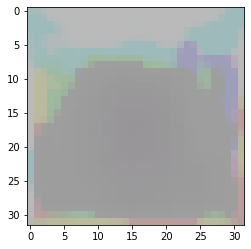

real:  59 fake:  64
d: 0.9609375   g: 0.0    gl: 2.410646438598633
real:  59 fake:  64
d: 0.9609375   g: 0.0    gl: 2.406099319458008
real:  59 fake:  64
d: 0.9609375   g: 0.0    gl: 2.399702310562134
real:  59 fake:  64
d: 0.9609375   g: 0.0    gl: 2.393218517303467
real:  59 fake:  64
d: 0.9609375   g: 0.0    gl: 2.3855061531066895
real:  58 fake:  64
d: 0.953125   g: 0.0    gl: 2.37847900390625
real:  58 fake:  64
d: 0.953125   g: 0.0    gl: 2.371516704559326
real:  58 fake:  64
e:  6 @@@@@@@@@@ d: 0.953125   g: 0.0


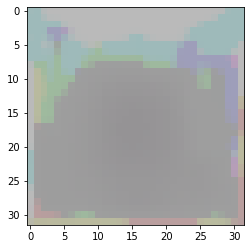

real:  58 fake:  64
d: 0.953125   g: 0.0    gl: 2.3659229278564453
real:  58 fake:  64
d: 0.953125   g: 0.0    gl: 2.3601438999176025
real:  58 fake:  64
d: 0.953125   g: 0.0    gl: 2.3547191619873047
real:  58 fake:  64
d: 0.953125   g: 0.0    gl: 2.3498833179473877
real:  58 fake:  64
d: 0.953125   g: 0.0    gl: 2.3431434631347656
real:  57 fake:  64
d: 0.9453125   g: 0.0    gl: 2.333350658416748
real:  57 fake:  64
d: 0.9453125   g: 0.0    gl: 2.324150323867798
real:  57 fake:  64
d: 0.9453125   g: 0.0    gl: 2.315333843231201
real:  57 fake:  64
e:  7 @@@@@@@@@@ d: 0.9453125   g: 0.0


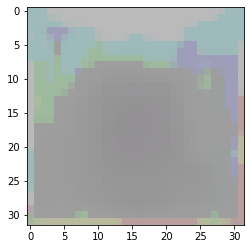

real:  57 fake:  64
d: 0.9453125   g: 0.0    gl: 2.3071300983428955
real:  57 fake:  64
d: 0.9453125   g: 0.0    gl: 2.2964930534362793
real:  57 fake:  64
d: 0.9453125   g: 0.0    gl: 2.279348134994507
real:  57 fake:  64
d: 0.9453125   g: 0.0    gl: 2.2607293128967285
real:  57 fake:  64
d: 0.9453125   g: 0.0    gl: 2.2417409420013428
real:  57 fake:  64
d: 0.9453125   g: 0.0    gl: 2.2205796241760254
real:  57 fake:  64
d: 0.9453125   g: 0.0    gl: 2.2010326385498047
real:  57 fake:  64
d: 0.9453125   g: 0.0    gl: 2.180370807647705
real:  57 fake:  64
e:  8 @@@@@@@@@@ d: 0.9453125   g: 0.0


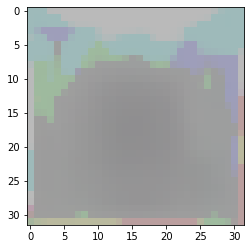

real:  57 fake:  64
d: 0.9453125   g: 0.0    gl: 2.160026788711548
real:  57 fake:  64
d: 0.9453125   g: 0.0    gl: 2.1376774311065674
real:  57 fake:  64
d: 0.9453125   g: 0.0    gl: 2.109560489654541
real:  57 fake:  64
d: 0.9453125   g: 0.0    gl: 2.074450969696045
real:  56 fake:  64
d: 0.9375   g: 0.0    gl: 2.0239949226379395
real:  56 fake:  64
d: 0.9375   g: 0.0    gl: 1.976102590560913
real:  56 fake:  64
d: 0.9375   g: 0.0    gl: 1.9309747219085693
real:  56 fake:  64
d: 0.9375   g: 0.0    gl: 1.890181303024292
real:  56 fake:  64
e:  9 @@@@@@@@@@ d: 0.9375   g: 0.0


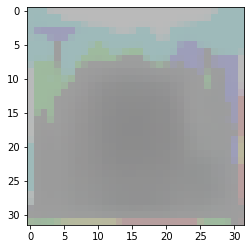

real:  56 fake:  64
d: 0.9375   g: 0.0    gl: 1.8539848327636719
real:  56 fake:  64
d: 0.9375   g: 0.0    gl: 1.8188703060150146
real:  56 fake:  64
d: 0.9375   g: 0.0    gl: 1.7863397598266602
real:  56 fake:  64
d: 0.9375   g: 0.0    gl: 1.7550793886184692
real:  56 fake:  64
d: 0.9375   g: 0.0    gl: 1.7238245010375977
real:  56 fake:  64
d: 0.9375   g: 0.0    gl: 1.6959865093231201
real:  56 fake:  64
d: 0.9375   g: 0.0    gl: 1.6708848476409912
real:  56 fake:  64
d: 0.9375   g: 0.0    gl: 1.6490263938903809
real:  56 fake:  64
e:  10 @@@@@@@@@@ d: 0.9375   g: 0.0


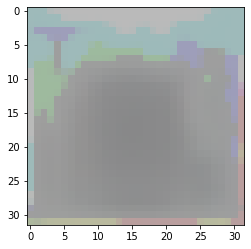

real:  56 fake:  64
d: 0.9375   g: 0.0    gl: 1.6298487186431885
real:  55 fake:  64
d: 0.9296875   g: 0.0    gl: 1.6078572273254395
real:  55 fake:  64
d: 0.9296875   g: 0.0    gl: 1.588782548904419
real:  55 fake:  64
d: 0.9296875   g: 0.0    gl: 1.5720841884613037
real:  55 fake:  64
d: 0.9296875   g: 0.0    gl: 1.5576893091201782
real:  55 fake:  64
d: 0.9296875   g: 0.0    gl: 1.545021653175354
real:  54 fake:  64
d: 0.921875   g: 0.0    gl: 1.5264451503753662
real:  54 fake:  64
d: 0.921875   g: 0.0    gl: 1.5155954360961914
real:  54 fake:  64
e:  11 @@@@@@@@@@ d: 0.921875   g: 0.0


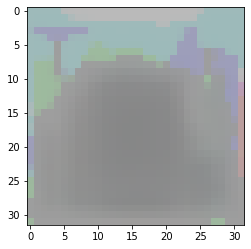

real:  54 fake:  64
d: 0.921875   g: 0.0    gl: 1.506617784500122
real:  54 fake:  64
d: 0.921875   g: 0.0    gl: 1.4936153888702393
real:  54 fake:  64
d: 0.921875   g: 0.0    gl: 1.480821967124939
real:  54 fake:  64
d: 0.921875   g: 0.0    gl: 1.4694339036941528
real:  54 fake:  64
d: 0.921875   g: 0.0    gl: 1.4592176675796509
real:  54 fake:  64
d: 0.921875   g: 0.0    gl: 1.4452216625213623
real:  54 fake:  64
d: 0.921875   g: 0.0    gl: 1.432603359222412
real:  54 fake:  64
e:  12 @@@@@@@@@@ d: 0.921875   g: 0.0


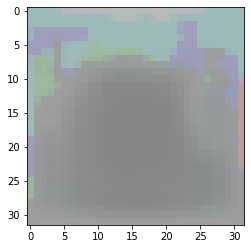

real:  54 fake:  64
d: 0.921875   g: 0.0    gl: 1.4227190017700195
real:  54 fake:  64
d: 0.921875   g: 0.0    gl: 1.4088332653045654
real:  54 fake:  64
d: 0.921875   g: 0.0    gl: 1.3976706266403198
real:  53 fake:  64
d: 0.9140625   g: 0.0    gl: 1.3834445476531982
real:  53 fake:  64
d: 0.9140625   g: 0.0    gl: 1.3700647354125977
real:  53 fake:  64
d: 0.9140625   g: 0.0    gl: 1.3574767112731934
real:  53 fake:  64
d: 0.9140625   g: 0.0    gl: 1.3454455137252808
real:  53 fake:  64
d: 0.9140625   g: 0.0    gl: 1.3338340520858765
real:  53 fake:  64
e:  13 @@@@@@@@@@ d: 0.9140625   g: 0.0


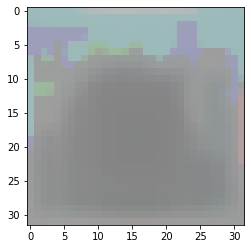

real:  53 fake:  64
d: 0.9140625   g: 0.0    gl: 1.3251172304153442
real:  53 fake:  64
d: 0.9140625   g: 0.0    gl: 1.3174395561218262
real:  53 fake:  64
d: 0.9140625   g: 0.0    gl: 1.3108081817626953
real:  53 fake:  64
d: 0.9140625   g: 0.0    gl: 1.3045501708984375
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 1.299468755722046
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 1.294644832611084
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 1.2907919883728027
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 1.2862038612365723
real:  52 fake:  64
e:  14 @@@@@@@@@@ d: 0.90625   g: 0.0


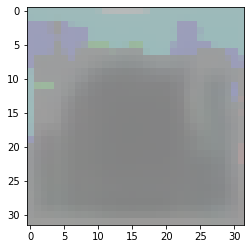

real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 1.2816760540008545
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 1.2748072147369385
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 1.2692770957946777
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 1.263925313949585
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 1.2592639923095703
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 1.2552847862243652
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 1.2524545192718506
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 1.249725341796875
real:  52 fake:  64
e:  15 @@@@@@@@@@ d: 0.90625   g: 0.0


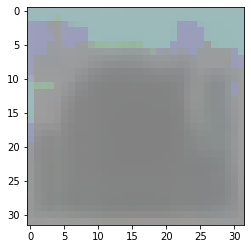

real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 1.247549295425415
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 1.2450810670852661
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 1.2431437969207764
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 1.235299825668335
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 1.2284737825393677
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 1.2221591472625732
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 1.2157479524612427
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 1.2105114459991455
real:  52 fake:  64
e:  16 @@@@@@@@@@ d: 0.90625   g: 0.0


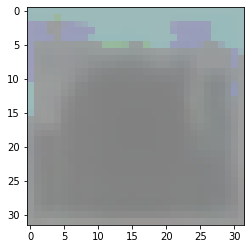

real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 1.2069779634475708
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 1.2027606964111328
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 1.200154423713684
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 1.197443962097168
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 1.194324254989624
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 1.1919751167297363
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 1.1897358894348145
real:  52 fake:  64
e:  17 @@@@@@@@@@ d: 0.90625   g: 0.0


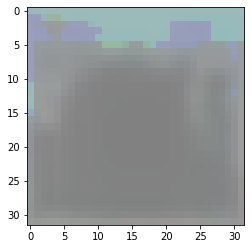

real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 1.1876811981201172
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 1.186539649963379
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9854741096496582
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.969303548336029
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9617328643798828
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9567179679870605
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9534572958946228
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9486023187637329
real:  52 fake:  64
e:  18 @@@@@@@@@@ d: 0.90625   g: 0.0


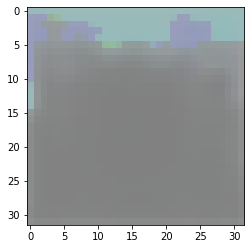

real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9434541463851929
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9405527114868164
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9382953643798828
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9375089406967163
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9372012615203857
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9369838237762451
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.93682461977005
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9349151849746704
real:  52 fake:  64
e:  19 @@@@@@@@@@ d: 0.90625   g: 0.0


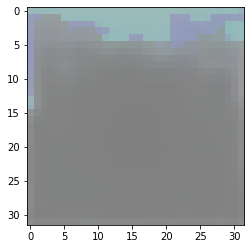

real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9343847036361694
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9324033260345459
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9318777322769165
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9318686723709106
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9312909841537476
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9311631917953491
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9314350485801697
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.930031418800354
real:  52 fake:  64
e:  20 @@@@@@@@@@ d: 0.90625   g: 0.0


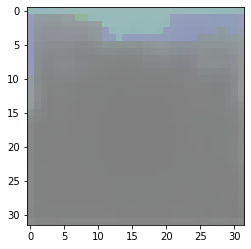

real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9304604530334473
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9274802207946777
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9273694753646851
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9269901514053345
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9267435669898987
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9262768030166626
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9237470626831055
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9219285845756531
real:  52 fake:  64
e:  21 @@@@@@@@@@ d: 0.90625   g: 0.0


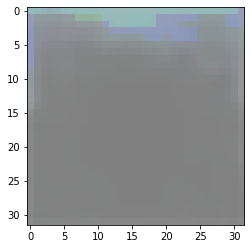

real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9209582805633545
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.919975757598877
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9188590049743652
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9178769588470459
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9147955179214478
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9117212891578674
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.9071105718612671
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.902863621711731
real:  52 fake:  64
e:  22 @@@@@@@@@@ d: 0.90625   g: 0.0


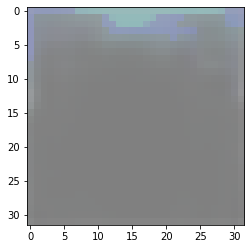

real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.8987393975257874
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.8942680358886719
real:  52 fake:  64
d: 0.90625   g: 0.0    gl: 0.8905118107795715


KeyboardInterrupt: 

In [136]:
count = 0

for epoch in range(1, epoch_num+1):
  for batch_idx, (real_images, _) in enumerate(train_loader):
    count += 1
    if real_images.shape[0] != batch_size:
      continue

    ri, fi = gen_real_fake_batch(real_images)

    if count % 100 == 0:
      # 1a. train discriminator (0/1) using real images
      d_optimizer.zero_grad()
      dis_real_oupt = d_net(ri)  # [0, 1]
      dis_real_loss = criterion(dis_real_oupt.squeeze(), all_ones)

      # 1b. train discriminator using fake images
      dis_fake_oupt = d_net(fi)
      dis_fake_loss = criterion(dis_fake_oupt.squeeze(), all_zeros)
      dis_loss_tot = dis_real_loss + dis_fake_loss

      dis_loss_tot.backward()
      d_optimizer.step()

    # 2. train gen with fake images and flipped labels
    g_optimizer.zero_grad()
    zz = gen_rand_imgs([batch_size, 100]).to(device)
    fake_images = g_net(zz)
    # norm_loss = get_norm_loss(fake_images)
    fake_images = torch.sigmoid(fake_images)
    dis_fake_oupt = d_net(fake_images)
    gen_loss = criterion(dis_fake_oupt.squeeze(), all_ones)
    # gen_loss += 0.0005 * norm_loss

    gen_loss.backward()
    g_optimizer.step()

    if count % 100 == 0:

      test_d_acc = test_discriminator_accuracy()
      test_g_eff = test_generator_efficiency()
      print('d:', test_d_acc, '  g:', test_g_eff, '   gl:', gen_loss.item())

  test_d_acc = test_discriminator_accuracy()
  test_g_eff = test_generator_efficiency()
  print('e: ', epoch, '@@@@@@@@@@ d:', test_d_acc, '  g:', test_g_eff)
  show_example()

print('complete')

In [25]:
for epoch in range(1, epoch_num + 1):
  print(epoch)
  d_net.train()
  g_net.train()

  for idx, imgs in enumerate(train_loader):
    optimizer.zero_grad()
    ri, fi, rl, fl = gen_real_fake_batch(imgs[0])
    ro = d_net(ri)
    fo = d_net(fi)
    real_loss = criterion(ro, rl.type(torch.float))
    fake_loss = criterion(fo, fl.type(torch.float))
    real_loss += fake_loss
    real_loss = real_loss.cuda()
    
    real_loss.backward()
    optimizer.step()
    
    if idx % 100 == 0:
      # print('@@@@', ro[:10], fo[:10])
      print('idx: ', idx, ' loss: ', real_loss.item())
      print('accuracy: ', test_discriminator_accuracy())

  print('aaaaaaaaaaaaaaaaaa accuracy: ', test_discriminator_accuracy())

1
idx:  0  loss:  1.3765780925750732
accuracy:  0.359375
idx:  100  loss:  0.6527634859085083
accuracy:  0.5
idx:  200  loss:  0.5072628259658813
accuracy:  1.0
idx:  300  loss:  0.2723243236541748
accuracy:  0.8671875
idx:  400  loss:  0.11385341733694077
accuracy:  0.8671875
idx:  500  loss:  0.05409223958849907
accuracy:  0.703125
idx:  600  loss:  0.031168930232524872
accuracy:  0.578125
idx:  700  loss:  0.019515855237841606
accuracy:  0.6328125
aaaaaaaaaaaaaaaaaa accuracy:  0.734375
2
idx:  0  loss:  0.014583422802388668
accuracy:  0.734375
idx:  100  loss:  0.009974643588066101
accuracy:  0.5390625
idx:  200  loss:  0.008359476923942566
accuracy:  0.4140625
idx:  300  loss:  0.0059466855600476265
accuracy:  0.8125
idx:  400  loss:  0.004520198330283165
accuracy:  0.734375
idx:  500  loss:  0.004471353255212307
accuracy:  0.8515625
idx:  600  loss:  0.003315683687105775
accuracy:  0.8671875
idx:  700  loss:  0.0026607427280396223
accuracy:  0.8203125
aaaaaaaaaaaaaaaaaa accuracy: 

KeyboardInterrupt: 

In [53]:
torch.save(d_net.state_dict(), 'd_net_1')

In [129]:
d_net.load_state_dict(torch.load('d_net'))

<All keys matched successfully>

In [131]:
d_net(gen_rand_imgs([1, 3, 32, 32]).to(device))

tensor([0.0819], device='cuda:0', grad_fn=<ViewBackward>)

In [132]:
img = None
for _, imgs in enumerate(train_loader):
  print(imgs[0][24].shape)
  img = imgs[0][24].reshape(1, 3, 32, 32)
  break

d_net(img.to(device))

torch.Size([3, 32, 32])


tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)

In [87]:
# set_model_freeze(g_net, False)
# set_model_freeze(d_net, True)

In [160]:
epoch_num = 10000
lr = 1e-3
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(g_net.parameters(), lr = lr)

In [161]:
def test_generator_efficiency():
  d_net.eval()
  g_net.eval()
  fake_imgs = gen_rand_imgs([64,3,32,32]).to(device)
  fake_lbls = gen_labels(64, 1).to(device)
  fake_imgs = g_net(fake_imgs)
  fake_preds = d_net(fake_imgs)

  fake_preds = torch.round(fake_preds)
  d_net.train()
  g_net.train()
  return torch.sum(fake_preds == fake_lbls).item() / 64

In [162]:
test_generator_efficiency()

0.0

In [163]:
optimizer.zero_grad()
for epoch in range(1, epoch_num + 1):
  fake_imgs = gen_rand_imgs([64,3,32,32]).to(device)
  fake_lbls = gen_labels(64, 1).to(device)
  d_net.train()
  g_net.train()
  fake_imgs = g_net(fake_imgs)
  fake_preds = d_net(fake_imgs)
  loss = criterion(fake_preds, fake_lbls.type(torch.float))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if epoch % 100 == 0:
    print(epoch)
    print(fake_preds[:10])
    print('loss: ', loss.item(), 'accuracy: ', test_generator_efficiency())
  


100
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0',
       grad_fn=<SliceBackward>)
loss:  0.0 accuracy:  1.0


KeyboardInterrupt: 

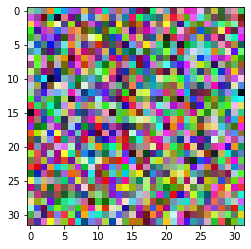

In [151]:
img_gtest = gen_rand_imgs([1,3,32,32])
plt.imshow(img_gtest[0].permute(1,2,0))

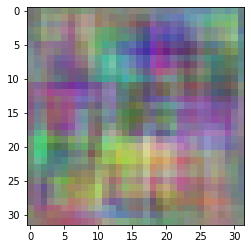

In [152]:
img_gtest = img_gtest.to(device)
img_gtest_out = g_net(img_gtest)
img_np = img_gtest_out.cpu()[0].permute(1,2,0).detach().numpy()
plt.imshow(img_np)

In [153]:
g_net.state_dict()['fin.weight'][0,0]

tensor([[-0.0175,  0.0200,  0.0340],
        [ 0.0113, -0.0061, -0.0257],
        [-0.0150, -0.0018,  0.0293]], device='cuda:0')

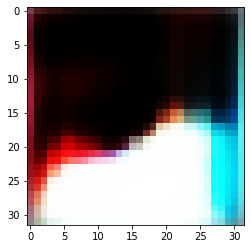

In [164]:
img_gtest_out = g_net(img_gtest)
img_np = img_gtest_out.cpu()[0].permute(1,2,0).detach().numpy()
plt.imshow(img_np)

In [165]:
g_net.state_dict()['fin.weight'][0,0]

tensor([[-0.0049,  0.0242,  0.0218],
        [ 0.0248,  0.0026, -0.0361],
        [-0.0005,  0.0086,  0.0256]], device='cuda:0')